# Insurance benefits prediction <a class='tocSkip'></a>

# Introduction

The insurance company Sure Tomorrow wants to solve several tasks with the help of machine learning and asks you to evaluate that possibility.

- Task 1: Find customers who are similar to a certain customer. This will help the company's agents with marketing.
- Task 2: Predict the probability that a new customer will receive an insurance benefit. Can a predictive model perform better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer may receive using a linear regression model.
- Task 4: Protect clients' personal data without affecting the model from the previous exercise. It is necessary to develop a data transformation algorithm that makes it difficult to retrieve personal information if the data falls into the wrong hands. This is called data masking or obfuscation. But the data must be protected in such a way that the quality of the machine learning models is not affected. 

It is not necessary to choose the best model, it is enough to demonstrate that the algorithm works correctly.

# Preprocessing and data exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from IPython.display import display


## Data load

Load the data and do a basic check to make sure there are no obvious problems.

In [2]:
# Load data into df
df = pd.read_csv('datasets/insurance_us.csv')

We rename the columns to make the code look more consistent with its style.

In [3]:
# Rename columns
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
# Get 10 random rows
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1008,1,37.0,52200.0,1,0
3587,1,22.0,29900.0,2,0
1573,0,27.0,36600.0,2,0
2805,0,47.0,32700.0,1,1
904,0,41.0,32500.0,0,0
4964,1,30.0,34500.0,0,0
4332,0,28.0,49500.0,3,0
4367,0,34.0,24600.0,1,0
3748,1,26.0,42200.0,1,0
1690,1,28.0,47700.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# Transform age and income to integer
df[['age','income']] = df[['age','income']].astype(int)

In [7]:
# Descriptive stats of numeric variables
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


The data comprises 5000 client records with information on 6 characteristics (gender, age, income, number of family members and number of benefits). There are no missing values.

Descriptive statistics of the characteristics reveal that:

* There is a close 1:1 ratio between males and females. 
* The age range of the insured is 18 to 65, the average age of the clients is ~31.
* Income ranges from \\$5,300 to \\$79,000; median salary is \\$42,200.
* The number of family members the insured has ranges from 0 to 6; 50\% of clients have at least one family member.
* The vast majority of clients (>75\%) have no insurance benefits.

Now let's explore the data visually.

## Explorative Data Analysis

Let's quickly check if certain customer groups exist by creating a pair plot.

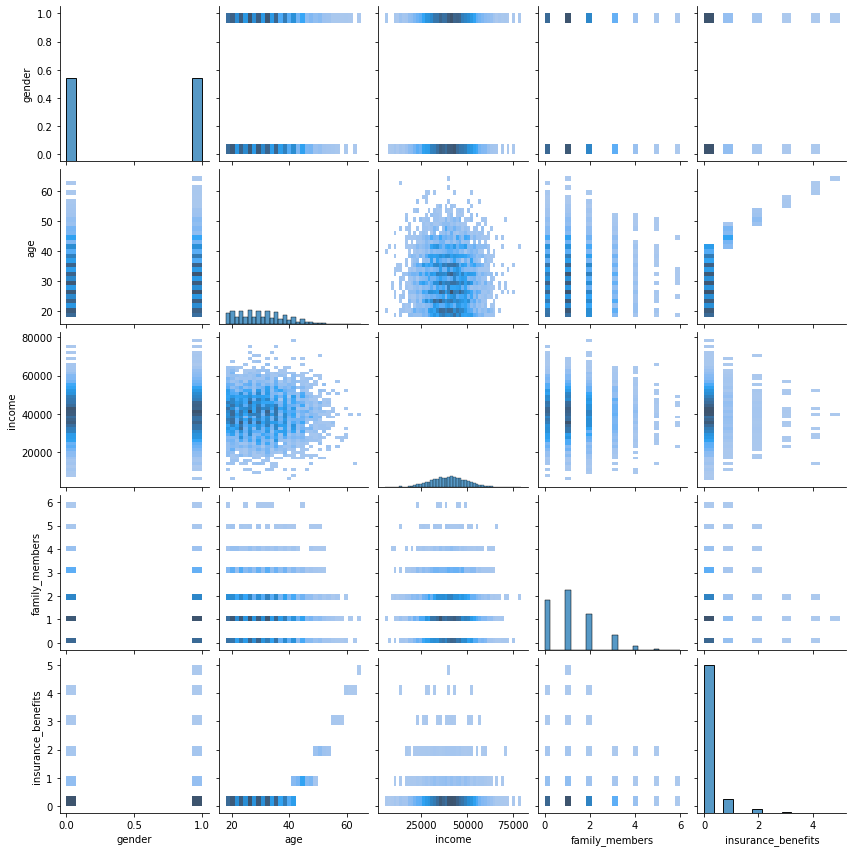

In [8]:
# Pair plot
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

In [9]:
# Matrix correlation
df.corr()

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.002074,0.014910,-0.008991,0.010140
age,0.002074,1.000000,-0.019093,-0.006692,0.651030
income,0.014910,-0.019093,1.000000,-0.030296,-0.014963
family_members,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
insurance_benefits,0.010140,0.651030,-0.014963,-0.036290,1.000000


It is a bit tricky to detect obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). According to the correlation heat map, it seems that there is a relationship between the age of the costumer and the insurance benefits he or she recieves.

# Task 1. Similar customers

In the ML language, you need to develop a procedure that returns the k nearest neighbors (objects) for a given object based on the distance between the objects.

To solve the task, we can try different distance metrics.

Write a function that returns the k nearest neighbors for an $n^{th}$ object based on a specified distance metric. When performing this task, the number of insurance benefits received should not be taken into account.

You can use an existing implementation of the kNN algorithm from scikit-learn (see [link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or your own implementation.

- Try it for four combinations of two cases- Scaling
    - the data is not scaled
    - the data is scaled with the scaler [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)

- Distance metrics
  - Euclidean
  - Manhattan

Answer these questions:- Does the fact that the data is not scaled affect the kNN algorithm? If so, how does it manifest itself:- How similar are the results when using the Manhattan distance metric (regardless of scaling)?

In [10]:
# Features selection
feature_names = ['gender', 'age', 'income', 'family_members']

In [11]:
def get_knn(df, n, k, metric='euclidean'):
    
    """
    Returns k nearest neighbors

    :param df: Pandas DataFrame used to find similar objects within the same location.    
    :param n: number of objects for which nearest neighbors are sought    
    :param k: number of k nearest neighbors to return
    :param metric: name of the distance metric
        euclidean': computes Euclidean distance between peers
        cityblock': computes manhattan distance between peers
    """

    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric).fit(df[feature_names].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [12]:
# Scale features
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [13]:
# Data scaled head
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1042,0.0,0.507692,0.750633,0.333333,0
924,0.0,0.476923,0.620253,0.000000,0
765,1.0,0.323077,0.401266,0.333333,0
1101,1.0,0.369231,0.374684,0.000000,0
1580,0.0,0.292308,0.470886,0.333333,0


Now, we are going to obtain similar records for a given customer, for each combination. Let's select the customer with index `101` which has the following characteristics:

In [14]:
# Client with index 101
df.loc[[101]]

,gender,age,income,family_members,insurance_benefits
101,0,49,42500,1,2


In [15]:
# 5 records similar to client number 101 - data NOT scaled - Euclidean distance
get_knn(df, n=101, k=6, metric='euclidean')

,gender,age,income,family_members,insurance_benefits,distance
101,0,49,42500,1,2,0.000000
1235,0,47,42500,2,1,2.236068
4753,0,39,42500,2,0,10.049876
2064,0,39,42500,0,0,10.049876
2969,0,37,42500,1,0,12.000000
1483,0,37,42500,1,0,12.000000


In [16]:
# 5 records similar to client number 101 - data NOT scaled - Manhattan
get_knn(df, n=101, k=6, metric='cityblock')

,gender,age,income,family_members,insurance_benefits,distance
101,0,49,42500,1,2,0.0
1235,0,47,42500,2,1,3.0
4753,0,39,42500,2,0,11.0
2064,0,39,42500,0,0,11.0
2969,0,37,42500,1,0,12.0
1483,0,37,42500,1,0,12.0


In [17]:
# 5 records similar to client number 101 - data scaled - Euclidean distance
get_knn(df_scaled, n=101, k=6, metric='euclidean')

,gender,age,income,family_members,insurance_benefits,distance
101,0.0,0.753846,0.537975,0.166667,2,0.000000
3023,0.0,0.753846,0.513924,0.166667,2,0.024051
1194,0.0,0.738462,0.511392,0.166667,1,0.030713
1951,0.0,0.723077,0.540506,0.166667,1,0.030873
4555,0.0,0.784615,0.544304,0.166667,2,0.031413
723,0.0,0.784615,0.522785,0.166667,2,0.034314


In [18]:
# 5 records similar to client number 101 - data Scaled - Manhattan
get_knn(df_scaled, n=101, k=6, metric='cityblock')

,gender,age,income,family_members,insurance_benefits,distance
101,0.0,0.753846,0.537975,0.166667,2,0.000000
3023,0.0,0.753846,0.513924,0.166667,2,0.024051
1951,0.0,0.723077,0.540506,0.166667,1,0.033301
4555,0.0,0.784615,0.544304,0.166667,2,0.037098
1194,0.0,0.738462,0.511392,0.166667,1,0.041967
723,0.0,0.784615,0.522785,0.166667,2,0.045959


**Does the fact that the data is not scaled affect the kNN algorithm? If so, how does it manifest itself?** ** Does data scaling affect kNN algorithm? 

Data scaling affects the selection of nearest neighbors. The indices of the nearest neighbors ('records') to the client with index `101` using Euclidean distance are as follows:

* **Non-scaled**: `1235`, `2064`, `4753`, `1483`, `2969`.
* **Scaled**: `3023`, `1194`, `1951`, `4555`, `723`.

The nearest neighbors **do not match** if we use the unscaled or scaled data. Let's see if the cases are equally similar by selecting the indices returned by each model, we will make the selection on the unscaled database as it is easier to see the similarities and differences between the clients.

In [19]:
# Selection of 5 neighbors with NON-SCALED data - Euclidean distance
df.loc[[101, 1235, 2064, 4753, 1483, 2969]]

,gender,age,income,family_members,insurance_benefits
101,0,49,42500,1,2
1235,0,47,42500,2,1
2064,0,39,42500,0,0
4753,0,39,42500,2,0
1483,0,37,42500,1,0
2969,0,37,42500,1,0


In [20]:
# Selection of 5 neighbors with SCALED data - Euclidean distance
df.loc[[101, 3023, 1194, 1951, 4555, 723]]

,gender,age,income,family_members,insurance_benefits
101,0,49,42500,1,2
3023,0,49,40600,1,2
1194,0,48,40400,1,1
1951,0,47,42700,1,1
4555,0,51,43000,1,2
723,0,51,41300,1,2


At first glance it appears that when using the **unscaled** data the nearest neighbors tend to be identical in income (`income`) and gender (`gender`) but dissimilar in terms of age (`age` - average 39.8), number of family members (`family_members`) and benefits (`insurance_benefits`).

In contrast, when feeding the model with the **scaled data** the selection of nearest neighbors tends to be more similar in terms of gender, number of family members and to a greater degree the number of benefits. Although incomes are not identical among the selected clients, they are not very far from the target individual. The age of the 5 closest clients averages 49.2.

It appears that **training the kNN algorithm with scaled data yields more similar individuals in terms of their characteristics**.

**How similar are the results when using the Manhattan distance metric (regardless of scaling)?**

The indices returned by the kNN algorithm with either the Euclidean or Manhattan distance metric are **identical although with subtle differences in the positioning of the cases**. This regardless of whether we use scaled or unscaled data. Let's look at the 5 nearest neighbors to customer `101` using scaled data for each metric.

* **Euclidean**: `3023`, `1194`, `1951`, `4555`, `723`.
* **Manhattan**: `3023`, `1951`, `4555`, `1194`, `723`.

# Task 2. Is the client likely to receive an insurance benefit?

With the value of `insurance_benefits` greater than zero as a target, evaluate whether the kNN classification approach can perform better than the dummy model.
Instructions:

1. Build a dummy model, which in this case is simply a random model. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

2. Build a KNN-based classifier and measure its quality with the F1 metric for k=1...10 for both the original and scaled data. It would be interesting to see how k can influence the evaluation metric and if scaling the data makes any difference. You can use an existing implementation of the kNN ranking algorithm from scikit-learn (see [link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or your own implementation.


The probability of paying any insurance benefit can be defined as
$$
P\{\text{Insurance benefit}\}=\frac{\text{number of clients who have received any insurance benefit}}{\text{total number of clients}}.
$$

Divide all data corresponding to the training/testing stages respecting the ratio 70:30.

In [21]:
# Probability of insurance benefit
df['insurance_benefits_received'] = np.where(df['insurance_benefits']>0, 1, 0)

print(df['insurance_benefits_received'].sum() / len(df))

0.1128


There is a **0.1128** probability of receiving any benefit from **Sure Tomorrow**.

In [22]:
# Assess class imbalance with value_counts()
df['insurance_benefits_received'].value_counts(normalize=True)

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64

There is a class imbalance as ~89% did not receive any benefits while ~11% did.

# 2.1 Dummy model

In [23]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [24]:
# Output random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [25]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'Probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P=P, size=len(df['insurance_benefits_received']))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

Probability: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

Probability: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

Probability: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

Probability: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



We can see that the quality of the classification of the positive class (_i.e._ customers with benefits) is very poor according to the value of F1 no matter how the probability of receiving a benefit increases. This is mainly due to class imbalance.

# 2.2 KNN classifier

## Data subseting <a class='tocSkip'></a>

In [26]:
# Subset non-scaled data
df_train, df_valid = train_test_split(df, test_size=0.3, random_state = 12345)

# Subset size
print('Training subset:  ', df_train.shape[0])
print('Validation subset:', df_valid.shape[0])

# FEATURES and TARGET
# Training subset
train_features = df_train.drop(['insurance_benefits','insurance_benefits_received'], axis=1)
train_target   = df_train['insurance_benefits_received']

# Validation subset
valid_features = df_valid.drop(['insurance_benefits','insurance_benefits_received'], axis=1)
valid_target   = df_valid['insurance_benefits_received']

Training subset:   3500
Validation subset: 1500


In [27]:
# Subset Scaled data
df_scaled['insurance_benefits_received'] = np.where(df_scaled['insurance_benefits']>0, 1, 0)

dfs_train, dfs_valid = train_test_split(df_scaled, test_size=0.3, random_state = 12345)

# Subset size
print('Trainning subset: ', dfs_train.shape[0])
print('Validation subset:', dfs_valid.shape[0])

# FEATURES and TARGET
# Training subset
train_s_features = dfs_train.drop(['insurance_benefits','insurance_benefits_received'], axis=1)
train_s_target   = dfs_train['insurance_benefits_received']

# Validation subset
valid_s_features = dfs_valid.drop(['insurance_benefits','insurance_benefits_received'], axis=1)
valid_s_target   = dfs_valid['insurance_benefits_received']

Trainning subset:  3500
Validation subset: 1500


We divided both unscaled and scaled data into two sets: training and validation with a 70:30 ratio respectively. 

The training characteristics include: gender, age, income and number of family members. The target characteristic is only whether clients received a benefit or not (`insurance_benefit_received`).

## KNN classifier <a class='tocSkip'></a>

We are going to classify the data using a distance-based algorithm: KNN. This algorithm will classify each observation according to its nearest neighbors. 

The hyperparameters of the model to modify are:

* `n_neighbors`: is the number of neighbors (_k_) to consider to classify a given point. This value will be iterated from 1 to 10.

* weights`: set to `distance` it weights the weight of each point by the inverse of its distance, i.e. points closer to a given point will have a greater influence than neighbors farther away.

* `metric`: set to `euclidean` to calculate the Euclidean distance between points.

We will run our model using the unscaled and scaled values. 

In [28]:
# KNN non-scaled data
knn_ns_f1 = []

for k in range(1, 11):
    X = train_features.values
    y = train_target.values
    knn_model = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='euclidean')
    knn_model.fit(X, y)
    predicted_valid = knn_model.predict(valid_features)
    knn_f1 = sklearn.metrics.f1_score(valid_target, predicted_valid)
    knn_ns_f1.append(knn_f1)
    print(f'K = {k}, F1 score = {knn_f1:.2f}')

K = 1, F1 score = 0.61
K = 2, F1 score = 0.61
K = 3, F1 score = 0.55
K = 4, F1 score = 0.52
K = 5, F1 score = 0.51
K = 6, F1 score = 0.46
K = 7, F1 score = 0.44
K = 8, F1 score = 0.44
K = 9, F1 score = 0.42
K = 10, F1 score = 0.42


In [29]:
# KNN with scaled data
knn_s_f1 = []

for k in range(1, 11):
    X = train_s_features.values
    y = train_s_target.values
    knn_model = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='euclidean')
    knn_model.fit(X, y)
    predicted_valid = knn_model.predict(valid_s_features)
    knn_f1 = sklearn.metrics.f1_score(valid_s_target, predicted_valid)
    knn_s_f1.append(knn_f1)
    print(f'K = {k}, F1 score = {knn_f1:.2f}')

K = 1, F1 score = 0.97
K = 2, F1 score = 0.97
K = 3, F1 score = 0.95
K = 4, F1 score = 0.96
K = 5, F1 score = 0.95
K = 6, F1 score = 0.95
K = 7, F1 score = 0.96
K = 8, F1 score = 0.95
K = 9, F1 score = 0.95
K = 10, F1 score = 0.94


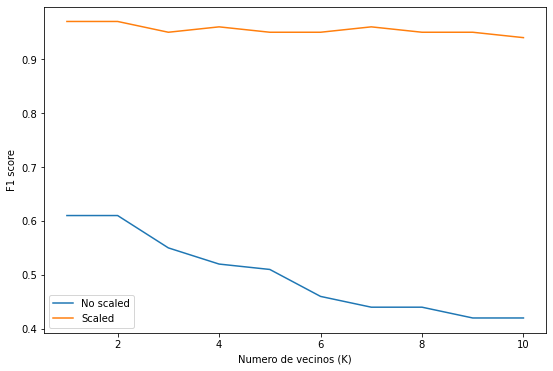

In [30]:
knn_f1_scores = pd.DataFrame({'no_scalated':knn_ns_f1, 'scalated':knn_s_f1}, index=[1,2,3,4,5,6,7,8,9,10])
knn_f1_scores[['no_scaled','scaled']] = np.round(knn_f1_scores[['no_scalated','scalated']],2)

plt.figure(figsize=(9,6))
plt.plot(knn_f1_scores['no_scaled'], label='No scaled')
plt.plot(knn_f1_scores['scaled'], label='Scaled')
plt.xlabel('Numero de vecinos (K)')
plt.ylabel('F1 score')
plt.legend()
plt.show()

The graph shows the change in the F1 score as the number of neighbors (_k_) increases in the KNN classification models using scaled and unscaled data. 

In general the value of **F1 decreases as the number of neighbors** to be considered for customer ranking increases. 

The model with scaled data (orange line) performs much better than with unscaled data (blue line).

# Task 3. Lineal regression

With `insurance_benefits` as a target, evaluate what the RMSE of a linear regression model would be.

Construct your own implementation of linear regression. To do this, recall how the solution of the linear regression task is formulated in terms of linear algebra. Check the RECM for both the original data and the scaled data. Can you see any difference in the RMSE with respect to these two cases?

Let us denote:
- $X$: feature matrix; each row is a case, each column is a feature, the first column consists of units
- $y$: target (a vector)
- $\hat{y}$ - estimated target (a vector)
- $w$ - vector of weights

The linear regression task in the language of matrices can be formulated as follows:
$$
y = Xw
$$

The training objective is then to find that $w$ which minimizes the L2 distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

There seems to be an analytical solution to the above:
$$
w = (X^T X)^{-1} X^T y
$$

The above formula can be used to find the weights $w$ and the weights $w$ can be used to calculate the predicted values
$$
\hat{y} = X_{val}w
$$

Divide all data corresponding to the training/testing stages respecting the 70:30 ratio. Use the RMSE metric to evaluate the model.

In [31]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # Add units
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) # Respuesta

    def predict(self, X):
        
        # Add units
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [32]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

## Linear regression with scaled and non-scaled data <a class='tocSkip'></a>

In [33]:
# Non-scaled data

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43538930e-01  3.57495491e-02  1.64272730e-02 -2.60745684e-07
 -1.16902138e-02]
RMSE: 0.34
R2: 0.66


In [34]:
# Scaled data

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353893  2.32372069  0.01642727 -0.02059891 -0.07014128]
RMSE: 0.34
R2: 0.66


Interestingly, **scaling the data has no effect** on the RECM (or RMSE) or the R2 score, since in both cases the metrics obtained identical values.

# Task 4. Obfuscate data

It is best to obfuscate the data by multiplying the numerical features (remember that they can be viewed as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do this and check how the values of the features will look like after the transformation. By the way, the invertibility property is important here, so make sure that $P$ is actually invertible.

In [35]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [36]:
X = df_pn.to_numpy()

Generate a random matrix $P$.

In [37]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Check that the matrix P is invertible

In [38]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Can you guess the age or income of customers after the transformation?

In [39]:
# Multiply matrix X by the random matrix P
X_prima = X.dot(P)

# Assess data ofuscation
x_original = pd.DataFrame(X, columns = personal_info_column_list)
x_transformada = pd.DataFrame(X_prima, columns = personal_info_column_list)

print(x_original.head())
print(x_transformada.head())

   gender  age  income  family_members
0       1   41   49600               1
1       0   46   38000               1
2       0   29   21000               0
3       0   21   41700               2
4       1   28   26100               0
        gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631
3  5345.603937  18803.227203  15479.148373    38663.061863
4  3347.176735  11782.829283   9699.998942    24211.273378


When printing the two matrices X and X' (x_transformed), it can be seen that it is not possible to determine the original data from X', the data have been correctly obfuscated. 

Can you recover the original $X'$ data if you know $P$? Try to check it through calculations by moving $P$ from the right side of the above formula to the left side. In this case the rules of matrix multiplication are really useful

In [40]:
x_recuperada = pd.DataFrame(X_prima.dot(np.linalg.inv(P)), columns = personal_info_column_list)
print(x_recuperada.head())

         gender   age   income  family_members
0  1.000000e+00  41.0  49600.0    1.000000e+00
1 -4.473636e-12  46.0  38000.0    1.000000e+00
2 -2.515869e-12  29.0  21000.0    9.524523e-13
3 -4.844982e-12  21.0  41700.0    2.000000e+00
4  1.000000e+00  28.0  26100.0   -1.019907e-13


Shows the three cases for some customers
- Original data
- The one that is transformed
- The one that is inverted (recovered)

In this case we are going to show customers with index 10, 100 and 1000.

In [41]:
# Original data
x_original.iloc[[10,100,1000]]

,gender,age,income,family_members
10,1,25,36600,1
100,0,19,37300,1
1000,1,41,42600,1


In [42]:
# Transformed data
x_transformada.iloc[[10,100,1000]]

,gender,age,income,family_members
10,4692.731211,16509.777526,13591.538192,33940.174806
100,4781.071734,16818.755070,13845.671372,34583.496545
1000,5462.919844,19227.703111,15828.504572,39513.341768


In [43]:
# Recovered data
x_recuperada.iloc[[10,100,1000]]

,gender,age,income,family_members
10,1.000000e+00,25.0,36600.0,1.0
100,-4.615196e-12,19.0,37300.0,1.0
1000,1.000000e+00,41.0,42600.0,1.0


The values retrieved through the inverse are not equal due to the multiplication of decimals. To solve this problem we can round the values to one decimal place. The retrieved values are then rounded and stored in the `x_retrieved_rounded` matrix and the indexes of the selected customers are displayed.

In [44]:
# Rounded data
x_recuperada_redondeada = pd.DataFrame(np.round(X_prima.dot(np.linalg.inv(P)),1), columns = personal_info_column_list)

# Visualization of recovered data (rounded)
x_recuperada_redondeada.iloc[[10,100,1000]]

,gender,age,income,family_members
10,1.0,25.0,36600.0,1.0
100,-0.0,19.0,37300.0,1.0
1000,1.0,41.0,42600.0,1.0


## Proof that data obfuscation can work in linear regression

In this project the regression task has been solved with linear regression. Your next task is to demonstrate _analytically_ that the obfuscation method will not affect the linear regression in terms of predicted values, i.e. its values will remain the same. 

The data is obfuscated and we now have $X \times P$ instead of having just $X$. Consequently, there are other weights $w_P$ such as

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

* How would $w$ and $w_P$ be related if we simplified the formula for $w_P$ above? 

* What would be the predicted values with $w_P$? 

* What does this mean for the quality of linear regression if this is measured by RECM?

**Answer**

In the training formula, we can multiply the feature matrix $X$ by the random matrix $P$ to create an algorithm that makes it difficult to retrieve personal information from the transformed data.

**Analytical test**

By multiplying the feature matrix $X$ by the transformation matrix $P$, we obtain the transformed feature matrix $X'$:
$$X' = XP$$

Then:
$$w' = (X'^{T}X')^{-1}X'^{T} y = (X^{T}P^{T}XP)^{-1} X^{T}P^{T}y$$

Due to the **reversibility of the transpose** of a product of matrices:
$$(AB)^{T} = B^{T}A^{T}$$

Then:
$$w' = (P^{T}X^{T}XP)^{-1}P^{T}X^{T}y$$

Due to property of **multiplicative identity**: $(AB)^{-1}=B^{-1}A^{-1}$ we have:
$$w' = P^{-1}(P^{T}X^{T}X)^{-1}P^{T}X^{T}y$$
$$w' = P^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T}y$$

Given $A^{-1}A = 1$ we have:
$$w' = P^{-1}(X^{T}X^{-1})X^{T}y$$
$$w' = P^{-1}w$$

To verify that our predictions ($\hat{y'}$) will be identic:
$$\hat{y'} = X'w'$$

Knowing that:
$$X' = XP$$
$$w' = P^{-1}w$$
$$\hat{y} = Xw$$

Then:
$$\hat{y'} = XPP^{-1}w$$
$$\hat{y'} = Xw$$
$$\hat{y'} = \hat{y}$$

## Linear regression test with data obfuscation

Now, let's prove that linear regression can work, computationally, with the chosen obfuscation transformation.

Build a procedure or a class that optionally runs linear regression with obfuscation. You can use a linear regression implementation from scikit-learn or your own implementation.

Run the linear regression for the original and the obfuscated data, compare the predicted values and the values of the RMSE and $R^2$ metrics. Is there any difference?

**Procedure**.

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If it is not, repeat the first step until an invertible matrix is obtained.
- If the matrix $P$ is invertible, multiply it by the feature matrix $X$ to generate a matrix with masked data: $XP$.
- Use $XP$ as the new feature matrix.

In [45]:
# Creation of a square matrix P of random numbers
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
X = df_pn.to_numpy()

rng = np.random.default_rng(seed=24)
P = rng.random(size=(X.shape[1], X.shape[1]))

# Check that it is reversible
print(np.linalg.inv(P),'\n')

# Creation of XP as a new feature matrix
XP = X.dot(P)

# Transformation from feature matrix to DataFrame
XP = pd.DataFrame(X_prima, columns = personal_info_column_list)

# Size DataFrame XP
print(XP.shape,'\n')

# XP viz
XP.head()

[[-2.43510503 -0.67956337  1.6356644   1.03209417]
 [ 0.0249708  -0.31553386  1.46239737 -0.97142918]
 [ 1.35753434  1.9368603  -2.01365293 -0.04885137]
 [ 2.00216398 -1.50257     0.0485452   0.15957602]] 

(5000, 4) 



,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


In [46]:
# Subset of transformed data
XP_train, XP_test, y_train, y_test = train_test_split(XP, y, test_size=0.3, random_state=12345)

In [47]:
# Linear regression with masked data

lr_mask = MyLinearRegression()

lr_mask.fit(XP_train, y_train)
print(lr_mask.weights)

y_test_pred_mask = lr_mask.predict(XP_test)
eval_regressor(y_test, y_test_pred)

[-0.94353896 -0.05791721 -0.01546569  0.09871892 -0.02397536]
RMSE: 0.34
R2: 0.66


In [48]:
# Linear regression with original data
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43538930e-01  3.57495491e-02  1.64272730e-02 -2.60745684e-07
 -1.16902138e-02]
RMSE: 0.34
R2: 0.66


Data obfuscation or masking does not affect the predictions or the quality of the linear regression model as demonstrated in the analytical test.

# Conclusions

Two models have been used in this project: a classification model for the clustering of similar clients in terms of whether or not they receive at least one benefit from the insurer and a regression model for the prediction of the number of benefits received by each client.

The clustering of similar customers was performed through a nearest neighbor number (KNN) model using different distance metrics (Euclidean and Manhattan) and with scaled and unscaled data. The results did not differ according to the metric used but the use of scaled data clustered similar clients better than when using unscaled data.

The data were masked using a random matrix and it was found that the information concerning the personal data of each customer is impossible to infer from the transformed data. It was also found that knowing the random matrix it is possible to recover the original data although with slight differences.

Subsequently, it was verified analytically that data masking does not affect the predictions and therefore the quality of the model. A linear regression model was computed with masked and original data, both models arrived at the same predictions and with an identical quality score (RECM and R2).